# Checking fetched data

Note that some things we found out here were worked into fetching (part 1).

In [15]:
import collections

import wetsuite.helpers.localdata
import wetsuite.helpers.notebook
import wetsuite.helpers.meta
import wetsuite.helpers.koop_parse

In [ ]:
op_fetched             = wetsuite.helpers.localdata.LocalKV( 'op_fetched.db', str, bytes )

## Basic summary

e.g. 
- how much have we fetched in each area?
- what file types have we fetched?

And let's count split per area - we could get overall totals from that later, if we wanted.

In [ ]:
# this is functionally just a dict-in-dict structure 
#   (this syntax trickery just makes the logic below look a little nicer)
count_area_type_count = collections.defaultdict( lambda: collections.defaultdict(int) ) # but  

bads = [] # also build a list of identifiers we don't understand, in case we want to inspect them

# for a large store this may take a minute
for fetched_url in op_fetched.keys(): 
    basename = fetched_url.rsplit('/',1)[1]
    if 'metadata' in basename: 
        typ = 'metadata_xml' # metadata is .xml, make this difference clearer in the labels
    else:
        typ = basename.rsplit('.',1)[1]

    try:
        bkid = wetsuite.helpers.koop_parse.parse_repo_url(fetched_url)['doc_id']  # cleanish way to fish the id out of that URL 
        pid = wetsuite.helpers.meta.parse_bekendmaking_id( bkid )
        area = pid['type']
    except ValueError as ve:
        area = 'BAD'
        bads.append( bkid )

    count_area_type_count[area][typ] += 1 # actual counting

In [4]:
# ...and print those counts
for area, typdict in count_area_type_count.items():
    print( f'{area:<6s}   {dict(typdict)}' )    

ag-ek    {'metadata_xml': 1019, 'xml': 1019}
ag-tk    {'metadata_xml': 1194, 'xml': 1177, 'pdf': 17}
ag-vv    {'metadata_xml': 30, 'xml': 30}
ag       {'metadata_xml': 72, 'pdf': 72}
ah-ek    {'metadata_xml': 441, 'xml': 441}
ah-tk    {'metadata_xml': 86727, 'xml': 86726, 'pdf': 1}
ah       {'metadata_xml': 533, 'pdf': 532, 'xml': 3}
bgr      {'html': 2, 'metadata_xml': 12497, 'xml': 12495}
blg      {'metadata_xml': 96848, 'pdf': 96841, 'xml': 4702}
gmb      {'metadata_xml': 3794891, 'xml': 3767253, 'html': 562, 'pdf': 29274, 'odt': 23}
BAD      {'html': 1, 'metadata_xml': 498, 'xml': 498, 'pdf': 1}
h-ek     {'metadata_xml': 10258, 'xml': 10258}
h-tk     {'metadata_xml': 47579, 'xml': 47578, 'pdf': 1}
h-vv     {'metadata_xml': 53, 'xml': 53}
h        {'metadata_xml': 50, 'pdf': 44, 'xml': 6}
kst      {'metadata_xml': 340592, 'xml': 337155, 'pdf': 19418, 'odt': 3}
kv       {'metadata_xml': 23932, 'xml': 23437, 'pdf': 4978}
kv-tk    {'metadata_xml': 40960, 'xml': 40960}
nds-tk   {'metada

,metadata_xml,xml,pdf,html,odt
ag-ek,1019,1019,0,0,0
ag-tk,1194,1177,17,0,0
ag-vv,30,30,0,0,0
ag,72,0,72,0,0
ah-ek,441,441,0,0,0
ah-tk,86727,86726,1,0,0
ah,533,3,532,0,0
bgr,12497,12495,0,2,0
blg,96848,4702,96841,0,0
gmb,3794891,3767253,29274,562,23


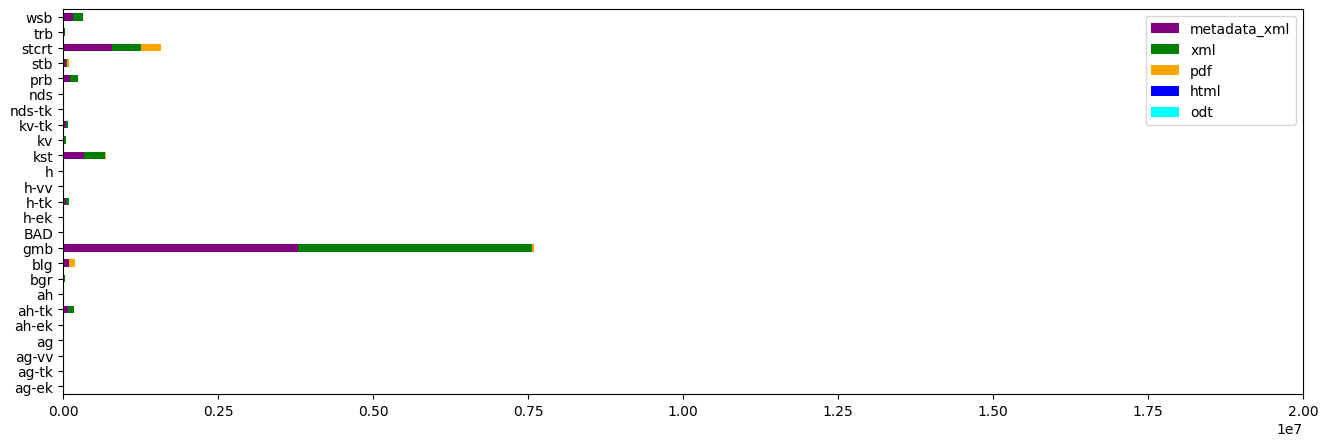

In [13]:
# draw the counts per area, to reproduce the second plot in the introduction above
#   but now a little more accurately, with the PDFs that we needed.
import pandas
colors = {'xml':'green', 'odt':'cyan','odf':'cyan', 'html':'blue', 'pdf':'orange', 'metadata_xml':'purple'}

df = pandas.DataFrame.from_dict(count_area_type_count, orient='index')   # from_dict happens to wrangle that nested structure well enough
df.plot.barh( stacked=True, figsize=(16, 5), xlim=(0,2E7), color=colors, log=False) # log=True would make all the small ones show up, but loses easy comparability
display( df.fillna(0).astype(int) )

## Finding peculiarities


### Non-value items, duplicates

We mentioned some non-data items before. How common is that? (note: this is where we discovered this; the fix has been worked into the above)

Also, we might care to inspect the very-small documents, to see if there are any cases we need to care about.
It turns out that aside from single-sentence real documents, there are also cases where the document was later removed, e.g. 
[trb-2020-38](https://repository.overheid.nl/frbr/officielepublicaties/trb/2020/trb-2020-38/1/html/trb-2020-38.html)
(which does not seem to be reflected in [the metadata](https://repository.overheid.nl/frbr/officielepublicaties/trb/1982/trb-1982-10/1/metadata/metadata.xml))

Also, since we copied some values, we are worried about mistaken duplicates due to code mistakes (we found some, and removed them).

Most of that touches the actual document contents, so let's check them at the same time.

Things we found in the process, some of which informed some of the above
- there are XMLs that have no body tag at all, just the meta
- there are XMLs that have a template of structure with 
- there are cases where the XML's content is basically "look at the PDF instead"
- there are cases of 'vervallen'
- there are cases of 'verwijderd' but they seem to be HTML instead (?)

On duplicates:
- There is a set of 170+ duplicates coming from the content being a HTML document containing "Deze publicatie is op verzoek van de publicerende organisatie verwijderd."
e.g. [gmb-2020-27421.html](https://repository.overheid.nl/frbr/officielepublicaties/gmb/2020/gmb-2020-27421/1/html/gmb-2020-27421.html), [gmb-2016-186077.html](https://repository.overheid.nl/frbr/officielepublicaties/gmb/2016/gmb-2016-186077/1/html/gmb-2016-186077.html), [gmb-2021-402686.html](https://repository.overheid.nl/frbr/officielepublicaties/gmb/2021/gmb-2021-402686/1/html/gmb-2021-402686.html), [gmb-2015-41225.html](https://repository.overheid.nl/frbr/officielepublicaties/gmb/2015/gmb-2015-41225/1/html/gmb-2015-41225.html)
- The following: [stb-1985-223-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-223-n1/1/pdf/stb-1985-223-n1.pdf), [stb-1985-238-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-238-n1/1/pdf/stb-1985-238-n1.pdf), [stb-1985-239-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-239-n1/1/pdf/stb-1985-239-n1.pdf), [stb-1985-240-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-240-n1/1/pdf/stb-1985-240-n1.pdf), [stb-1985-245-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-245-n1/1/pdf/stb-1985-245-n1.pdf), [stb-1985-246-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-246-n1/1/pdf/stb-1985-246-n1.pdf), [stb-1985-249-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-249-n1/1/pdf/stb-1985-249-n1.pdf), [stb-1985-254-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-254-n1/1/pdf/stb-1985-254-n1.pdf), [stb-1985-260-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-260-n1/1/pdf/stb-1985-260-n1.pdf), [stb-1985-261-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-261-n1/1/pdf/stb-1985-261-n1.pdf), [stb-1985-262-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-262-n1/1/pdf/stb-1985-262-n1.pdf), [stb-1985-263-n1.pdf](https://repository.overheid.nl/frbr/officielepublicaties/stb/1985/stb-1985-263-n1/1/pdf/stb-1985-263-n1.pdf) are all the same PDF, because it seems to be a note that corrects those twelve. 
- There are some duplicates from PDFs presumably  being attachments to different things, e.g. [blg-996801.pdf](https://repository.overheid.nl/frbr/officielepublicaties/blg/onopgemaakt/blg-996801/1/pdf/blg-996801.pdf), [blg-997146.pdf](https://repository.overheid.nl/frbr/officielepublicaties/blg/onopgemaakt/blg-997146/1/pdf/blg-997146.pdf), and [blg-997497.pdf](https://repository.overheid.nl/frbr/officielepublicaties/blg/onopgemaakt/blg-997497/1/pdf/blg-997497.pdf). 
- There are under 4000 cases like this in 11 million documents (...within the subset of types that we fetched, anyway...), and most cases have just two documents, and seemingly most of them in `blg` and `kst`

In [ ]:
count_cases = collections.defaultdict(int)      # the different descriptions of weirdness

# collect lists of cases for some of those types
wrong       = [] # key
verwijderd  = [] # key
other_small = [] # (key, size, content)    to make them faster to inspect after
niethtml    = [] # key

hashes      = collections.defaultdict(list)     # contenthash -> [urls it came from], used for the duplicate check


op_fetched_keys = list(op_fetched.keys())
pbar = wetsuite.helpers.notebook.progress_bar(len(op_fetched_keys))
for key in op_fetched_keys:
    found_new_dup = False

    doc_bytes = op_fetched.get(key)

    
    if key.endswith('.xml'):

        # Look for XMLs that seem wrong
        if False: # (to possibly disable)
            try:
                tree = wetsuite.helpers.etree.fromstring( doc_bytes )
            except Exception:
                pass

            if 'metadata' in key:
                if tree.tag != 'metadata_gegevens':
                    print(f'{repr(key)} URL seems like metadata but root node is {tree.tag}')
                    count_cases['wrong_1'] += 1
                    wrong.append(key)
            else: # .xml and not metadata -- which should mean data
                if tree.tag not in ('officiele-publicatie', 'kamerwrk','handeling','vraagdoc','stcart','staatsbl','trblad','avvcao','staatscourant','staatsblad','vblad',
                                    'kamerstuk','opdracht','vraagdoc','cao',
                                    '{https://standaarden.overheid.nl/lvbb/stop/uitlevering/}OfficielePublicatie',
                                    ):
                    print(f'{repr(key)} URL seems like data but root node is {tree.tag}')
                    wrong.append(key)
                    count_cases['wrong_2'] += 1

        # Look for XMLs that seem empty,  or suspiciously small
        if True: # (to possibly disable)
            if len(doc_bytes) < 1500:
                if b'Deze publicatie is op verzoek van publicerende organisatie verwijderd' in doc_bytes:
                    count_cases['verwijderd'] += 1
                    verwijderd.append( key )

                elif b'niet beschikbaar in HTML-formaat' in doc_bytes:
                    count_cases['nietHTML'] += 1
                    niethtml.append( key )

                # ...both of which also makes it small, but not very interesting to report as such, so the following is on an else:
                else:
                    try:
                        # look for empty XMLs. These may have to be re-fetched as PDF
                        seems_empty = wetsuite.helpers.koop_parse.op_data_xml_seems_empty( doc_bytes ) 
                    except ValueError as ve:
                        print()
                        print(ve)
                        print(doc_bytes)
                        count_cases['xml error'] += 1
                        continue

                    if seems_empty:
                        count_cases['notext'] += 1
                        #print( f'NOTEXT {key} - {len(bytedoc)} - {bytedoc}')
                    else: # not empty, but tiny amount of text
                        count_cases['other_small'] += 1
                        other_small.append( (key, len(doc_bytes), doc_bytes) )
                        #print( f'TINY {key} - {len(bytedoc)}- {bytedoc}')

    # Look for content duplicates 
    #  SLOW, because it reads your entire store
    #  ...and probably not interesting once you have done it once
    
    if False: # (to possibly disable)
        dochash = wetsuite.helpers.util.hash_hex( doc_bytes )
        if dochash in hashes: # already in there?
            found_new_dup = True
        hashes[dochash].append( key )
        
        if found_new_dup: 
            # report as we go, so we would print each _addition_ to a dupset;
            #   we could do it afterwards but it'd be a lot of waiting to see anything
            print(f'DUP {dochash} within {hashes[dochash]}')
            #for url in hashes[dochash]:
            #    udoc = op_fetched.get(url)
            #    print(dochash, wetsuite.helpers.util.hash_hex( udoc ), udoc)

    pbar.value += 1
    pbar.description = ', '.join(f'{k}:{v}'   for k,v in count_cases.items()) 
    #pbar.description = f'deletes:{deletes}  wrong:{len(wrong)}, verwijderd:{len(verwijderd)}, notext:{notext}, other_small:{len(other_small)}'

In [ ]:
list( count_cases.items() )

[('nietHTML', 1143),
 ('notext', 404791),
 ('other_small', 807223),
 ('xml error', 212),
 ('verwijderd', 49)]

### office documents?

There are only a few of those `.odt` files that our preference logic let in.

It may well be that these are intended _but rare_. 

Or it may be that some documents are kept as documents while new (and editable?), and a PDF is introduced once finalized.


Looking at one such set, [kst-21501-32-565](https://repository.overheid.nl/frbr/officielepublicaties/kst/21501-32/kst-21501-32-565/1/) _now_ has odt and pdf, 
but at some time our store had only downloaded an odt. 

...yet is is not recent, so neither theory holds.  So probably we _did_ briefly get our preference logic slightly wrong in an older version of this notebook (it is unlikely someone was 12 years late making the PDF).

If we ever start caring about being both _quite_ correct and very up to date, this would be interesting to figure out.
For now we assume we ignore this is fine, 

There are a bunch of things that do not have XML, but do have PDF.   

From looking at the list, it seems...
- most seem to be onopgemaakt documents in `blg`, e.g. [blg-1003144](https://repository.overheid.nl/frbr/officielepublicaties/blg/onopgemaakt/blg-1003144/1/)
  - It seems that these are attachments in the practical sense -- not core documents, but relevant to attach.  Often scanned, with PDF seeminly chosen as a nice interchange format.
- a few cases in ah-tk,. e.g. [ah-tk-20092010-145-h1](https://repository.overheid.nl/frbr/officielepublicaties/ah-tk/20092010/ah-tk-20092010-145-h1/1) 
  - these seem few enough that they are somehow exceptions? TODO: check
- a lot of further cases seem onopgemaakt in ah
  - e.g. [ah-815604](https://repository.overheid.nl/frbr/officielepublicaties/ah/onopgemaakt/ah-815604/1) are not new at all, but only have PDFs.
    - TODO
  - or [ah-1151601](https://repository.overheid.nl/frbr/officielepublicaties/ah/onopgemaakt/ah-1151601/) -- which does not have _any_ content online. So why do I even think I know this identifier?  Let's check that.  The URL comes from something this notebook previously fetched - it has metadata and data for that identifier. To wit (the URLs come from finding that ID in all keys):

In [13]:
display( wetsuite.helpers.etree.debug_color(  # knowing it's an XML, show it prettier
    op_fetched.get('https://repository.overheid.nl/frbr/officielepublicaties/ah/onopgemaakt/ah-1151601/1/metadata/metadata.xml')
) )

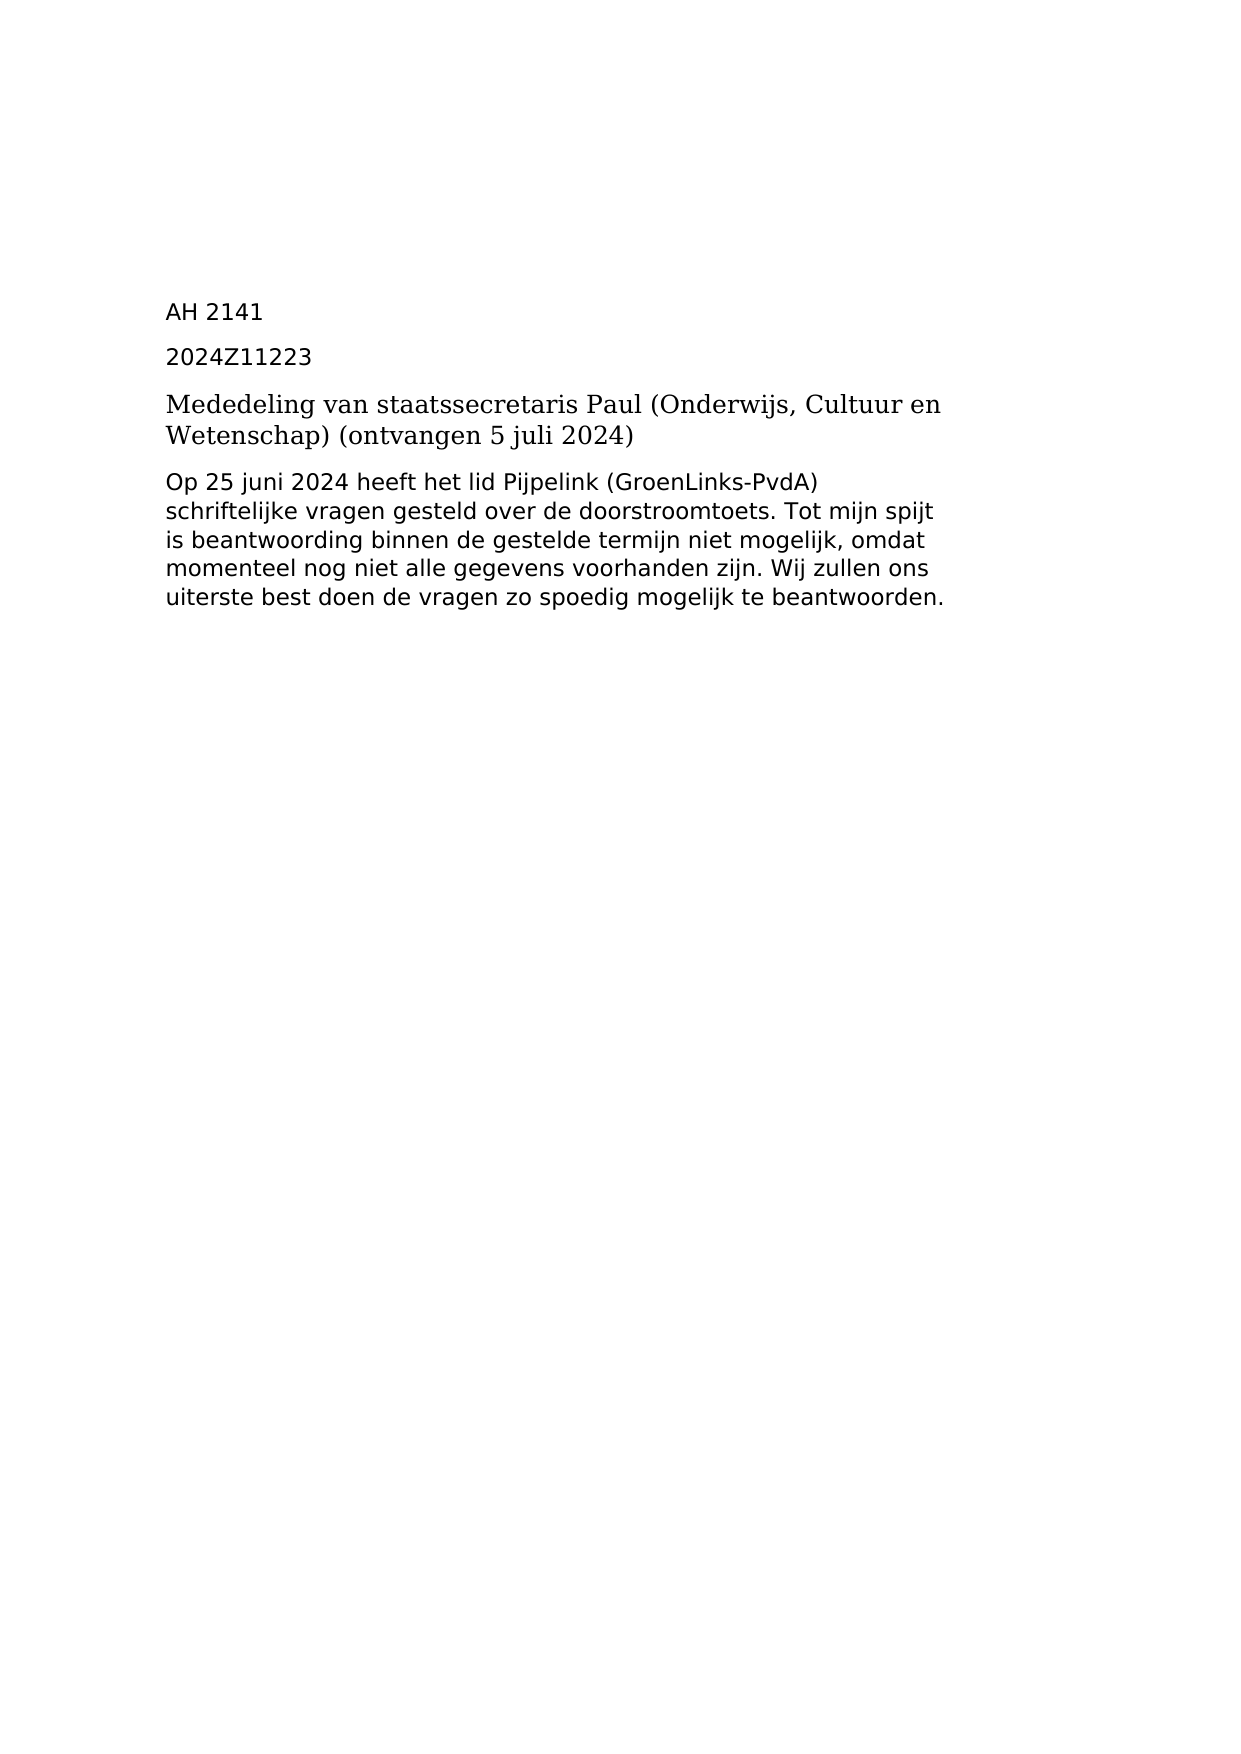

In [15]:
import wetsuite.extras.pdf  # knowing it's a PDF, get the first page as image
next( wetsuite.extras.pdf.pages_as_images( 
    op_fetched.get('https://repository.overheid.nl/frbr/officielepublicaties/ah/onopgemaakt/ah-1151601/1/pdf/ah-1151601.pdf')
) )

That was quite recent at the time of writing, and presumably got replaced by and actual answer, which would be fair enough.